# **ML Mildew Detector**

## Objectives

* Answer business requirement 1:
    - The client is interested to have a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew.
## Inputs

* inputs/mildew_dataset/cherry-leaves/train
* inputs/mildew_dataset/cherry-leaves/test
* inputs/mildew_dataset/cherry-leaves/validation

## Outputs

* Image shape embeddings pickle file.
* Mean and variability of images per label plot (eg: healthy, powdery_mildew).
* Plot to distinguish the contrast between healthy and powdery-mildew infected cherry leave images.
* Generate code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard.

## Additional Comments

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\All\\Desktop\\Zoe_Deve\\ML-Mildew-Detector-\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\All\\Desktop\\Zoe_Deve\\ML-Mildew-Detector-'

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Set input directories for train, validation and test paths

In [5]:
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
version = 'v1-mildew'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

## Set label names

In [7]:
# Set the labels
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

# Data visualisation Study

## Set standardised Image shape

Compute average images size on train set.

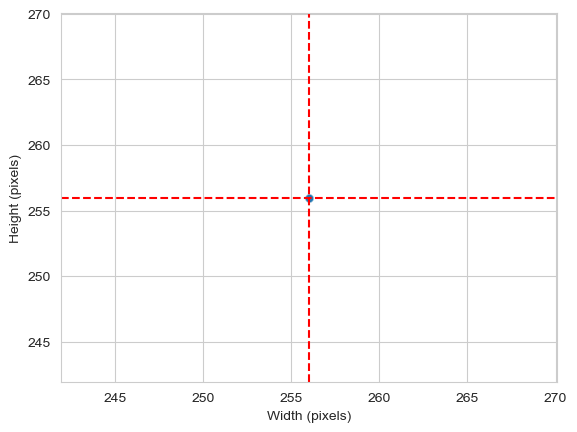

Width average: 256 
Height average: 256


In [8]:
# Below code is taken from CI walk through notebook
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

Assign the average width and height, and color channel to image_shape

In [9]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

Save the image shape embeddings

In [10]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1-mildew/image_shape.pkl']

## Average and variability of images for healthy and powdery-mildew contained cherry leaves

Function to load images in an array (tensor)

In [6]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

ModuleNotFoundError: No module named 'tensorflow'

In [14]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

TypeError: argument 1 must be sequence of length 2, not 3

## Split train validation test set

In [11]:
 # This below function was taken from CI training notebook

import os
import shutil
import random
import joblib


def split_train_validation_test_images(my_data_dir, train_set_ratio, validation_set_ratio, test_set_ratio):

    if train_set_ratio + validation_set_ratio + test_set_ratio != 1.0:
        print("train_set_ratio + validation_set_ratio + test_set_ratio should sum to 1.0")
        return

    # gets classes labels
    labels = os.listdir(my_data_dir)  # it should get only the folder name
    if 'test' in labels:
        pass
    else:
        # create train, test folders with classes labels sub-folder
        for folder in ['train', 'validation', 'test']:
            for label in labels:
                os.makedirs(name=my_data_dir + '/' + folder + '/' + label)

        for label in labels:

            files = os.listdir(my_data_dir + '/' + label)
            random.shuffle(files)

            train_set_files_qty = int(len(files) * train_set_ratio)
            validation_set_files_qty = int(len(files) * validation_set_ratio)

            count = 1
            for file_name in files:
                if count <= train_set_files_qty:
                    # move a given file to the train set
                    shutil.move(my_data_dir + '/' + label + '/' + file_name,
                                my_data_dir + '/train/' + label + '/' + file_name)

                elif count <= (train_set_files_qty + validation_set_files_qty):
                    # move a given file to the validation set
                    shutil.move(my_data_dir + '/' + label + '/' + file_name,
                                my_data_dir + '/validation/' + label + '/' + file_name)

                else:
                    # move given file to test set
                    shutil.move(my_data_dir + '/' + label + '/' + file_name,
                                my_data_dir + '/test/' + label + '/' + file_name)

                count += 1

            os.rmdir(my_data_dir + '/' + label)

We will then divide the dataset conventionally to train set 0.7, validation set 0.10 and test set 0.20

In [13]:
split_train_validation_test_images(my_data_dir=f"inputs/mildew_dataset/cherry-leaves",
                                   train_set_ratio=0.7,
                                   validation_set_ratio=0.1,
                                   test_set_ratio=0.2
                                   )

---

# Conclusions and Next Steps

* We've now cleaned dataset and divide them into training set, validation set and test set.
* Next notebook, we are ready to study the visual difference of a cherry leaf that is healthy from one that contains powdery mildew